# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [328]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [329]:
# Download the data (Commented out because downloaded onto local machine)
# if not os.path.exists('/content/carseq.npy'):
#     !wget https://www.cs.cmu.edu/~deva/data/carseq.npy -O /content/carseq.npy
# if not os.path.exists('/content/girlseq.npy'):
#     !wget https://www.cs.cmu.edu/~deva/data/girlseq.npy -O /content/girlseq.npy

# Q2.1: Theory Questions (5 points)
Please refer to the handout for the detailed questions.

## Q2.1.1: What is $\frac{\partial \mathbf{W}(\mathbf{x};\mathbf{p})}{\partial \mathbf{p}^{T}}$? (**Hint**: It should be a 2x2 matrix)

===== your answer here! =====

$W(x;p)=x+p=\begin{bmatrix} x+p_x\\ y+p_y\end{bmatrix}$


$\frac{\partial \mathbf{W}(\mathbf{x};\mathbf{p})}{\partial \mathbf{p}^{T}}=\begin{bmatrix} 1 & 0\\ 0 & 1\end{bmatrix}$

===== end of your answer =====

## Q2.1.2: What is $\mathbf{A}$ and $\mathbf{b}$?

===== your answer here! =====

A is a transformation while b is a transformed set of points.

The original set of points is x.

===== end of your answer =====

## Q2.1.3 What conditions must $\mathbf{A}^{T}\mathbf{A}$ meet so that a unique solution to $\Delta \mathbf{p}$ can be found?

===== your answer here! =====

A^TA must be positive semi-definite.

===== end of your answer =====

# Q2.2: Lucas-Kanade (20 points)
Make sure to comment your code and use proper names for your variables.

In [330]:
from scipy.interpolate import RectBivariateSpline
from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0):
    """
    :param[np.array(H, W)] It   : Grayscale image at time t [float]
    :param[np.array(H, W)] It1  : Grayscale image at time t+1 [float]
    :param[np.array(4, 1)] rect : [x1 y1 x2 y2] coordinates of the rectangular template to extract from the image at time t,
                                  where [x1, y1] is the top-left, and [x2, y2] is the bottom-right. Note that coordinates
                                  [floats] that maybe fractional.
    :param[float] threshold     : If change in parameters is less than thresh, terminate the optimization
    :param[int] num_iters       : Maximum number of optimization iterations
    :param[np.array(2, 1)] p0   : Initial translation parameters [p_x0, p_y0] to add to rect, which defaults to [0 0]
    :return[np.array(2, 1)] p   : Final translation parameters [p_x, p_y]
    """

    # ===== your code here! =====
    # Hint: Iterate over num_iters and for each iteration, construct a linear system (Ax=b) that solves for a x=delta_p update
    # Construct [A] by computing image gradients at (possibly fractional) pixel locations.
    # We suggest using RectBivariateSpline from scipy.interpolate to interpolate pixel values at fractional pixel locations
    # We suggest using lstsq from numpy.linalg to solve the linear system
    # Once you solve for [delta_p], add it to [p] (and move on to next iteration)
    #
    # HINT/WARNING:
    # RectBivariateSpline and Meshgrid use inconsistent defaults with respect to 'xy' versus 'ij' indexing:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.ev.html#scipy.interpolate.RectBivariateSpline.ev
    # https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html

    p = p0

    px = p[0]
    py = p[1]

    i = 0
    delta_p_norm_square = threshold 

    x1 = rect[0]
    y1 = rect[1]
    x2 = rect[2]
    y2 = rect[3]

    # T_t = It[y1:y2+1,x1:x2+1]
    # T_t_flat = np.reshape(T_t, (T_t.size,1))

    dWdp = np.eye(2) 

    height = It.shape[0]
    width = It.shape[1]
    height_arr = np.arange(height)
    width_arr = np.arange(width)
    
    rbs_T_t = RectBivariateSpline(height_arr,width_arr,It)
    iX = np.arange(x1+px,x2+px+0.5,1)
    iY = np.arange(y1+py,y2+py+0.5,1)
    xgrid, ygrid = np.meshgrid(iX,iY,indexing="ij")
    T_t = rbs_T_t.ev(ygrid,xgrid).T
    T_t_flat = np.reshape(T_t, (T_t.size,1))

    rbs_IW = RectBivariateSpline(height_arr,width_arr,It1)
    gradientAllX = np.gradient(It1,axis=1)
    gradientAllY = np.gradient(It1,axis=0)
    rbs_gx = RectBivariateSpline(height_arr,width_arr,gradientAllX)
    rbs_gy = RectBivariateSpline(height_arr,width_arr,gradientAllY)

    while (i < num_iters) and (delta_p_norm_square >= threshold):
        px = p[0]
        py = p[1]
        
        iX = np.arange(x1+px,x2+px+0.5,1)
        iY = np.arange(y1+py,y2+py+0.5,1)
        xgrid, ygrid = np.meshgrid(iX,iY,indexing="ij")
        IW = rbs_IW.ev(ygrid,xgrid).T
        IW_flat = np.reshape(IW, (IW.size,1))

        gradientVecX = np.ravel(rbs_gx.ev(ygrid,xgrid).T)
        gradientVecY = np.ravel(rbs_gy.ev(ygrid,xgrid).T)
        gradientMatrix = np.vstack((gradientVecX,gradientVecY)).T # (pixPatch,2) gradient matrix

        A = gradientMatrix@dWdp
        b = T_t_flat-IW_flat

        delta_p = np.linalg.lstsq(A.T@A,A.T@b,rcond=None)[0]
        
        p = p + delta_p

        delta_p_norm_square = np.square(np.linalg.norm(delta_p,ord=2,keepdims=True))
        i = i + 1
 
    # plt.figure(2)
    # plt.imshow(T_t)
    # plt.figure(3)
    # plt.imshow(IW)
    # ===== End of code =====
    return p

## Debug Q2.2



A few tips to debug your implementation:
- Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. You should be able to see a slight shift in the template.

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

In [331]:
def draw_rect(rect,color):
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.gca().add_patch(patches.Rectangle((rect[0],rect[1]), w, h, linewidth=1, edgecolor=color, facecolor='none'))


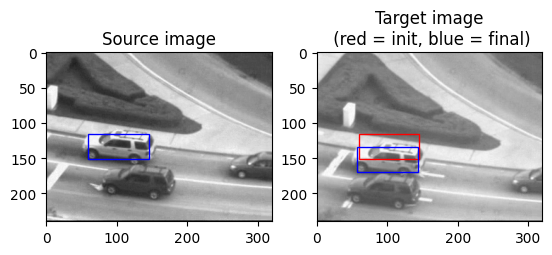

In [332]:
num_iters = 100
threshold = 0.01
seq = np.load("data\\carseq.npy")
rect = np.array([59, 116, 145, 151])
rect = np.reshape(rect, (rect.size,1))
It = seq[:,:,0]

# Source frame
plt.figure()
plt.subplot(1,2,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')
draw_rect(rect,'b')

# Target frame + LK
It1  = seq[:,:, 20]
plt.subplot(1,2,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image\n (red = init, blue = final)')
p = LucasKanade(It, It1, rect, threshold, num_iters, np.zeros((2,1)))

rect_t1 = (rect + np.concatenate((p,p)))

draw_rect(rect,'r')
draw_rect(rect_t1,'b')

## Q2.3: Tracking with template update (15 points)

In [333]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param seq       : (H, W, T), sequence of frames
    :param rect      : (4, 1), coordinates of template in the initial frame. top-left and bottom-right corners.
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, threshold for terminating the LK optimization
    :return: rects   : (T, 4) tracked rectangles for each frame
    """
    H, W, N = seq.shape

    rects = np.zeros((N,4))
    It = seq[:,:,0]
    pNow = np.zeros((2,1))
    #rect = np.reshape(rect, (4,1))

    # Iterate over the car sequence and track the car
    for i in range(seq.shape[2]):

        # ===== your code here! =====
        # TODO: add your code track the object of interest in the sequence
        if (i == seq.shape[2]-1):
            It = seq[:,:,i]
            It1 = seq[:,:,i]
        else:
            It = seq[:,:,i]
            It1 = seq[:,:,i+1]
        pNow = LucasKanade(It,It1,rect,threshold,num_iters,pNow)
        rects[i,:] = (np.copy(rect) + np.concatenate((pNow,pNow))).T  
        # ===== End of code =====

    #rects = np.array(rects)
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not ({N}x{4})"
    return rects

### Q2.3 (a) - Track Car Sequence

Run the following snippets. If you have implemented LucasKanade and TrackSequence function correctly, you should see the box tracking the car accurately. Please note that the tracking might drift slightly towards the end, and that is entirely normal.

Feel free to play with these snippets of code by playing with the parameters.

In [334]:
def visualize_track(seq,rects,frames,rect):
    # Visualize tracks on an image sequence for a select number of frames
    plt.figure(figsize=(15,15))
    for i in range(len(frames)):
        idx = frames[i]
        frame = seq[:, :, idx]
        plt.subplot(1,len(frames),i+1)
        plt.imshow(frame, cmap='gray')
        plt.axis('off')
        draw_rect(rects[idx],'b')
        draw_rect(rect,'r')

4
[[ 59]
 [116]
 [145]
 [151]]


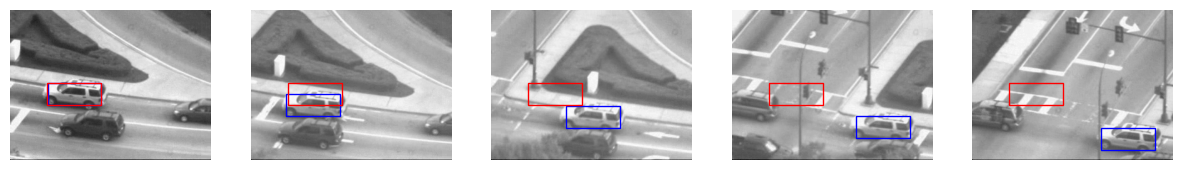

In [335]:
seq = np.load("data\\carseq.npy")
rect = np.array([59, 116, 145, 151])
print(rect.size)
rect = np.reshape(rect, (rect.size,1))
print(rect)


# NOTE: feel free to play with these parameters
num_iters = 10000
threshold = 0.01

rects = TrackSequence(seq, rect, num_iters, threshold)

#visualize_track(seq,rects,[0, 79, 159, 279, 409],rect)
scale = 20
visualize_track(seq,rects,[0*scale, 1*scale, 2*scale, 3*scale, 4*scale],rect) # Check your switching of p values around, might be messing it up maybe?

### Q2.3 (b) - Track Girl Sequence

Same as the car sequence.

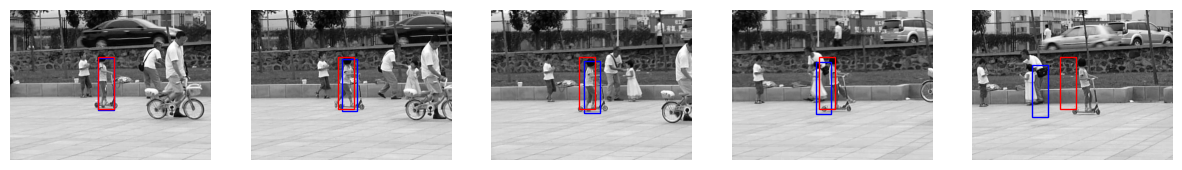

In [336]:
# Loads the squence
seq = np.load("data\\girlseq.npy")
rect = np.array([280, 152, 330, 318])
rect = np.reshape(rect, (rect.size,1))

# NOTE: feel free to play with these parameters
num_iters = 10000
threshold = 0.01

rects = TrackSequence(seq, rect, num_iters, threshold)

visualize_track(seq,rects,[0, 14, 34, 64, 84],rect)